In [1]:
import scipy as sp
import scipy.sparse.linalg
from scipy.spatial import ConvexHull
import numpy as np
import seaborn as sns
from cvxpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


eigs = sp.sparse.linalg.eigs

In [2]:
def generate_graph(n, frac, p, q, **kwargs):
    ''' 
    function to generate graph with 2 communities
    p is a probability of the edge inside clusters
    q is a probability of the edge between clusters
    '''
    if ("random_state" in kwargs):
        seed = kwargs["random_state"]
        np.random.seed(seed = seed)

    s1 = int(n*frac)
    s2 = n - s1
    g_in1 = p * np.ones((s1, s1))
    g_in2 = p * np.ones((s2, s2))
    g_out1 = q * np.ones((s1, s2))
    g_out2 = q * np.ones((s2, s1))

    P = np.bmat([[g_in1, g_out1], [g_out2, g_in2]])
    A = 1.0 * (np.random.rand(n, n) < P)
    true_comm = np.concatenate([ np.ones((s1, 1)), - np.ones((s2, 1))]).T

    cluster_1 = []
    cluster_2 = []
    for arg, node in enumerate(true_comm[0]):
        if node == 1:
            cluster_1.append(arg)
        else:
            cluster_2.append(arg)
    true_comm = [cluster_1, cluster_2]
    return P, A, true_comm

In [3]:
def create_pure_node_row(size, place_of_one=None):
    '''
    function to create a row with 'pure' node in Theta matrix
    size = Theta.shape[1] (Theta.shape[1] = number of communities)
    place_of_one = index of 1 in this row
    '''
    assert 0 <= place_of_one < size, "place_of_one >= size or < 0"
    return np.array([0] * place_of_one + [1] + [0]*(size - 1 - place_of_one))

In [4]:
def generate_theta(n_nodes, n_clusters, pure_nodes_number, alphas=None, seed=None):
    '''
    function to generate Theta matrix
    n_nodes = number of nodes
    n_clusters = number of communities
    pure_node_numbers = number of pure nodes in graph
    alphas = array in np.random.dirichlet
    '''
    
    if seed is not None:
        np.random.seed(seed)
        
    assert n_nodes >= n_clusters > 0, "n_clusters > n_nodes"
    assert 0 <= pure_nodes_number <= n_nodes, "number of pure nodes is not in [0; n_nodes]"
    
    if alphas is None:
        alphas = [1. / n_clusters] * n_clusters  ## default value is alpha = [1/k,..,1/k], k=n_clusters
    else:
        assert len(alphas) == n_clusters, "len of alphas != n_clusters"
    
    ### we generate two matrix. The first one is the matrix with only pure_nodes
    ### the second matrix is from dirichlet distribution
    ### further we concat them along axis=0
    dirichlet_node_distribution = np.random.dirichlet(alphas, size=n_nodes - pure_nodes_number) 
    pure_node_matrix = []
    for pure_node_idx in range(pure_nodes_number):
        pure_node_place = np.random.randint(low=0, high=n_clusters)
        pure_row = create_pure_node_row(n_clusters, pure_node_idx % n_clusters)
        pure_node_matrix.append(pure_row)
        
    pure_node_matrix = np.array(pure_node_matrix).reshape((pure_nodes_number, n_clusters))
    Theta = np.vstack([dirichlet_node_distribution, pure_node_matrix])
    Theta = np.random.permutation(Theta)
    #Theta2 = Theta[np.argsort(np.argmax(Theta, axis=1))]
    #return Theta2
    return Theta

In [5]:
def generate_P(n_nodes=5000, n_clusters=3, pure_nodes_number=None, B=None, Theta=None, alphas=None, seed=None):
    '''
    function to generate P matrix from Theta, B matrices
    '''
    if seed is not None:
        np.random.seed(seed)
        
    if pure_nodes_number is None:
        pure_nodes_number = n_clusters
    if alphas is None:
        alphas = [1. / n_clusters] * n_clusters
    else:
        assert len(alphas) == n_clusters, "len of alphas != n_clusters"
    
    assert n_nodes >= n_clusters, "n_clusters > n_nodes"
    assert 0 < pure_nodes_number <= n_nodes, "number of pure nodes is not in (0; n_nodes)"

    if Theta is None:
        Theta = generate_theta(n_nodes, n_clusters, pure_nodes_number, alphas, seed=seed)
    assert Theta.shape == (n_nodes, n_clusters), "Theta.shape != (n_nodes, n_clusters)"

    if B is None:
        B = np.diag(np.random.random(n_clusters))
    assert B.shape == (n_clusters, n_clusters), "B.shape != (n_clusters, n_clusters)"
    P = Theta.dot(B).dot(Theta.T)
    return P, Theta, B

In [6]:
def P_to_A(P, reflect = True, seed=None):
    '''
    function to generate A (adjacency matrix) from P (via bernoulli distribution)
    reflect parametrs is to reflect elements in A symmetrically along diagonal,
    default value is True
    '''
    if seed is not None:
        sp.random.seed(seed)
    A = sp.stats.bernoulli.rvs(P, random_state=seed)
    
    ### we reflect elements in A symmetrically along diagonal
    if reflect == True:
        i_lower = np.tril_indices(P.shape[0], -1)
        A[i_lower] = A.T[i_lower]
        return 1.*A
    return 1. * A

In [7]:
def generate_A(n_nodes=5000, n_clusters=3, pure_nodes_number=None, B=None, Theta=None, reflect=True, \
               alphas=None, seed=None):
    '''
    generate A matrix from params
    using P_to_A
    '''
    P, Theta, B = generate_P(n_nodes, n_clusters, pure_nodes_number, B, Theta, alphas, seed=seed)
    A = P_to_A(P, reflect=reflect)
    return A, Theta, B

In [8]:
def get_U_L(matrix, k):
    '''
    eigenvalue decomposition of symmetric matrix (U^-1 = U.T)
    matrix = U * L * U.T 
    k = n_clusters
    U.shape = (n_nodes, n_clusters) 
    L.shape = (n_clusters, n_clusters) is diagonal
    '''
    Lambda, U = eigs(matrix, k=k, which='LR')
    Lambda, U = np.diag(np.real(Lambda)), np.real(U)
    return U, Lambda

In [9]:
def get_Q(U):
    '''
    get positive semidefinite Q matrix of ellipsoid from U[i,:] vectors
    for any u_i in range(U[i,:], U.shape[0] <- number of nodes): 
        
            abs(u_i.T * Q * u_i) < 1
    requires: cvxpy (http://www.cvxpy.org/en/latest/)
    '''
    k = U.shape[1]
    Q = Semidef(n=k)
    hull = ConvexHull(U)
    constraints = [ abs( U[i,:].reshape((1,k))*Q*U[i,:].reshape((k,1)) ) < 1 for i in hull.vertices ]
    obj = Minimize(-log_det(Q))
    prob = Problem(obj, constraints)
    _ = prob.solve()
    Q = np.array(Q.value)
    return Q

In [10]:
A, Theta, B = generate_A(n_nodes=50, n_clusters=2, pure_nodes_number=10)
U, L = get_U_L(A, k=3)
Q = get_Q(U)

In [11]:
def transform_U(U, Q):
    '''
    U is matrix (n,k) shape, n = number of nodes, k is number of clusters
    transform U[i,:] coordinates to new basis where ellipsoid is a circle 
    Lambda = S.T * Q * S (Lambda is diagonal matrix (k,k)), where
    S is basis transformation matrix
    e' = e*S (for basis vectors)
    coordinates in new basis = S^-1 * coordinates in old basis
    Q is symmetric matrix ==> S^-1 = S.T
    new_coord = S.T * old_coord
    in order to make Lambda = Identity it is necessary to multiply S.T to np.sqrt(L)
    '''
    L, S = sp.linalg.eig(Q)
    S, L = np.real(S), np.diag(np.real(L))
    new_U = np.dot((S.T).dot(np.sqrt(L)), U.T).T
    return new_U

### examples of get_Q and transform_U

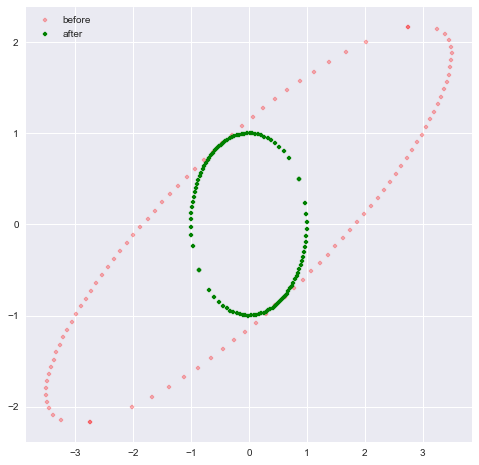

In [12]:
'''
Let points U belong circle with R=1 and center = (0,0)
Elong is a matrix of elongation in Ox and Oy
theta is an angle of rotation U points
M is a matrix of rotation
The first step is to elongate out u_i vectors and the second is to rotate them
'''

from math import cos, sin, pi

theta = pi/6
M = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
Elong = np.array([[2, 0], [0, 1]]) 

circle_x = np.linspace(-1., 1., 50)
circle_y  = np.array([np.sqrt(1.-x**2) for x in circle_x]) ## only positive values in circle_y

### tmp_U is U in this example
tmp_U = np.vstack((circle_x, circle_y))
tmp_U = np.hstack((tmp_U, np.vstack((circle_x, -circle_y))))
tmp_U = tmp_U.T

### transformation of tmp_U
tmp_U = M.dot(tmp_U.T).T
tmp_U = Elong.dot(tmp_U.T).T
tmp_Q = get_Q(tmp_U)
tmp_new_U = transform_U(tmp_U, tmp_Q)

plt.figure(figsize=(8, 8))
tmp_U = (M.dot(Elong.dot(tmp_U.T))).T
plt.scatter(x=tmp_U[:,0], y=tmp_U[:,1], c="r", alpha=0.3, marker='P', s = 10)
plt.scatter(x=tmp_new_U[:,0], y=tmp_new_U[:,1], c="g", marker='P', s=10)
plt.legend(["before", "after", "circle"], loc="best")

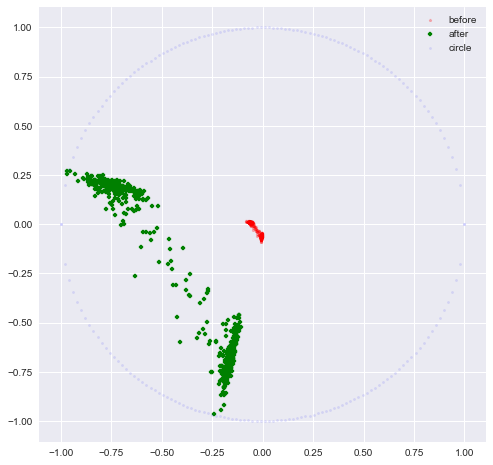

In [13]:
'''
experiment with generated data
'''
A, Theta, B = generate_A(n_nodes=500, n_clusters=2, pure_nodes_number=400)
U, L = get_U_L(A, k=2)
Q = get_Q(U)
new_U = transform_U(U, Q)
#print(np.max(U.dot(Q).dot(U.T)))

plt.figure(figsize=(8, 8))
plt.scatter(x=U[:,0], y=U[:,1], c="r", alpha=0.3, marker='2', s = 10)
plt.scatter(x=new_U[:,0], y=new_U[:,1], c="g", marker='P', s=10)

circle_x = np.linspace(-1., 1., 100)
circle_y  = np.array([np.sqrt(1.-x**2) for x in circle_x]) ## circle only for obviousness

plt.scatter(x=circle_x, y=circle_y, c='b', alpha=0.1, marker='.', s=20)
plt.scatter(x=circle_x, y=-circle_y, c='b', alpha=0.1, marker='.', s=20)
plt.legend(["before", "after", "circle"], loc="best")

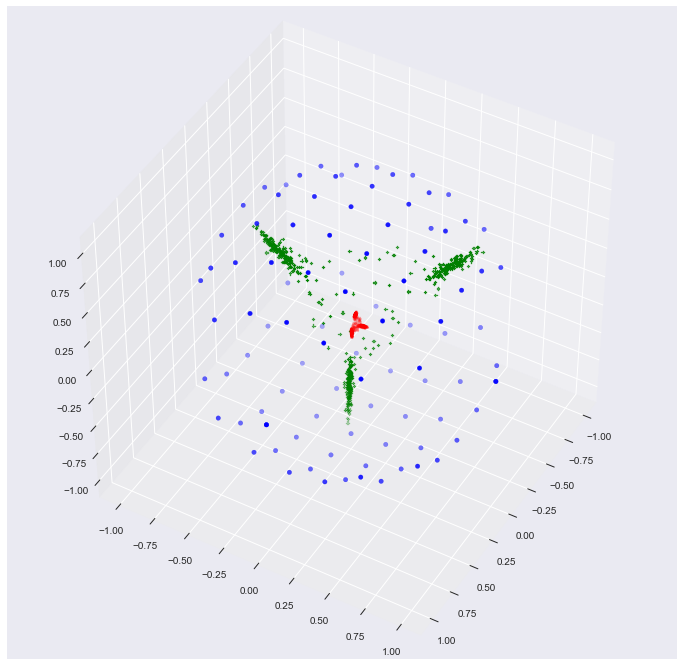

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

A, Theta, B = generate_A(n_nodes=500, n_clusters=3, pure_nodes_number=400)
U, L = get_U_L(A, k=3)
Q = get_Q(U)
new_U = transform_U(U, Q)
#print(np.max(U.dot(Q).dot(U.T)))

ax.scatter(U[:,0], U[:,1], U[:,2], c="r", alpha=0.3, marker='2', s = 10)
ax.scatter(new_U[:,0], new_U[:,1], new_U[:,2], c="g", marker='P', s=10)

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
xlen, ylen = len(X), len(Y)
X, Y = np.meshgrid(X,Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sqrt(1-X**2 - Y**2) 

surf = ax.scatter(X, Y, Z, c = "b")
surf = ax.scatter(X, Y, -Z, c="b")
ax.view_init(45,30)

In [15]:
def get_F_B(U, Lambda, cut=True):

    '''
    compute F, B from U matrix
    via using get_Q() to find Q matrix of ellipsoid
    and using transform_U(U,Q) to calculate new coordinate of u_i vectors
    '''
    k = U.shape[1]
    Q = get_Q(U)
    new_U = transform_U(U, Q)
    
    ### find k the biggest vectors in u_i
    ### and define f_j = u_i for 
    J = set()
    i = 0
    while i < k:
        j_indexes = np.argsort(-np.sum(new_U ** 2, axis=1))
        r = 0
        j_ = j_indexes[r]
        while j_ in J:
            j_ = j_indexes[r]
            r += 1
        u = new_U[j_, :]
        u = u.reshape((u.shape[0], 1))
#         print(u.dot(u.T).shape)
#         print((u.T.dot(u)).shape)
        new_U = (np.diag([1.] * new_U.shape[1]) - u.dot(u.T) / (u.T.dot(u))).dot(new_U.T)
        new_U = new_U.T
#         print(new_U.shape)
        J.add(j_)
        i += 1
#     print(len(J))
    F = new_U[list(J), :]
#     print(F.shape)
#     print(Lambda.shape)
    B = F.dot(Lambda).dot(F.T)
    B = (B - np.min(B))/(np.max(B) - np.min(B))
    return F, B

In [15]:
F, B_exp = get_F_B(U, L)

In [16]:
F

array([[  6.36286972e-17,   1.12891942e-17,   1.06603086e-18],
       [ -2.23856450e-18,   2.06157103e-17,   0.00000000e+00],
       [  1.58254014e-18,  -9.06018466e-18,  -3.40816176e-17]])

In [17]:
B

array([[ 0.21635162,  0.        ,  0.        ],
       [ 0.        ,  0.22880963,  0.        ],
       [ 0.        ,  0.        ,  0.44540349]])

In [18]:
B_exp

array([[  1.00000000e+00,   1.87916768e-02,   3.09715913e-02],
       [  1.87916768e-02,   7.74758917e-02,   0.00000000e+00],
       [  3.09715913e-02,   4.60352257e-18,   1.68001863e-01]])

In [19]:
def get_Theta(U, F):
    '''
    function to find Theta from U and F via
    convex optimization in cvxpy
    requires: cvxpy (http://www.cvxpy.org/en/latest/)
    '''
    
    assert U.shape[1] == F.shape[0] == F.shape[1], "U.shape[1] != F.shape"
    n_nodes = U.shape[0]
    n_clusters = U.shape[1]
    
    Theta = Variable(rows = n_nodes, cols = n_clusters)
    constraints = [sum_entries(Theta[i,:])==1 for i in range(n_nodes)]
    constraints  += [Theta[i,j] >= 0 for i in range(n_nodes) for j in range(n_clusters)]
    obj = Minimize(norm(U - Theta*F, 'fro'))
    prob = Problem(obj, constraints)
    prob.solve()
    print(Theta.value)
    return np.array(Theta.value)